In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import sys
import os
from torch.utils.data import DataLoader

In [87]:
# compactly add project src and analysis/zero-shot to sys.path if not already present
for rel in ('../../src', 'analysis/forecasting'):
    p = os.path.abspath(os.path.join(os.getcwd(), rel))
    if p not in sys.path:
        sys.path.append(p)

# now imports that rely on those paths
from utils import SequentialDeepONetDataset
from helper import convert2dim, fit, compute_metrics_region, load_model_experiment, plot_field_region

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Load Datasets

In [90]:
# input data shape (8400, 12)
# trunk shape (361 * 181, 2)
# target shape (8400, 361 * 181)

#input_data = np.random.randn(8400, 12)        
#trunk = np.random.randn(361 * 181, 2)        
#target = np.random.randn(8400, 361 * 181)

input_data = np.load('data/neutron_data_22yrs.npy')
trunk = np.load('data/grid_points.npy')
target = np.load('data/dose_array.npy')

print("Input data shape:", input_data.shape)
print("Trunk shape:", trunk.shape)
print("Target shape:", target.shape)

Input data shape: (8400, 12)
Trunk shape: (65341, 2)
Target shape: (8400, 65341)


In [91]:
from forecasting_analysis import create_windows_forecasting_with_index

In [92]:
dates = pd.date_range("2001-01-01", "2023-12-31", freq="D")

W, H = 30, 1
X_all, y_all, tgt_idx = create_windows_forecasting_with_index(input_data, target, W, H)
tgt_dates = dates[tgt_idx]

train_mask = (tgt_dates <= pd.Timestamp("2021-12-31"))
val_mask   = (tgt_dates >= pd.Timestamp("2022-01-01")) & (tgt_dates <= pd.Timestamp("2022-12-31"))
test_mask  = (tgt_dates >= pd.Timestamp("2023-01-01")) & (tgt_dates <= pd.Timestamp("2023-12-31"))

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val,   y_val   = X_all[val_mask],   y_all[val_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

# check shapes
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: torch.Size([7640, 30, 12]) torch.Size([7640, 65341])
Validation set: torch.Size([365, 30, 12]) torch.Size([365, 65341])
Test set: torch.Size([365, 30, 12]) torch.Size([365, 65341])


In [118]:
# first_test_idx = np.where(test_mask)[0][0]
# print("First test target date:", tgt_dates[first_test_idx])
# print("Input window covers:",
#       dates[first_test_idx : first_test_idx + W])

In [93]:
scaler_input = MinMaxScaler()
X_train_scaled = scaler_input.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled   = scaler_input.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled  = scaler_input.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [94]:
scaler_target = MinMaxScaler()
y_train_scaled = scaler_target.fit_transform(y_train)[..., np.newaxis]
y_val_scaled   = scaler_target.transform(y_val)[..., np.newaxis]
y_test_scaled  = scaler_target.transform(y_test)[..., np.newaxis]

In [95]:
# create datasets
#train_dataset = SequentialDeepONetDataset(X_train, trunk, y_train_scaled)
#val_dataset   = SequentialDeepONetDataset(X_val, trunk, y_val_scaled)
#test_dataset  = SequentialDeepONetDataset(X_test, trunk, y_test_scaled)

train_dataset = SequentialDeepONetDataset(X_train_scaled, trunk, y_train_scaled)
val_dataset   = SequentialDeepONetDataset(X_val_scaled,   trunk, y_val_scaled)
test_dataset  = SequentialDeepONetDataset(X_test_scaled,  trunk, y_test_scaled)

# create dataloaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## TRON

In [96]:
from helper import init_model
from forecasting_analysis import train_model

In [97]:
model = init_model()

In [98]:
# history = train_model(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     device=device,
#     scaler_target=scaler_target,
#     num_epochs=200,
#     lr=1e-3,
#     weight_decay=1e-4,
#     scheduler_step=20,
#     scheduler_gamma=0.7,
#     early_stop_patience=20,
#     save_path="analysis/forecasting/tron_forecast.pt"
# )


[Epoch 001] Train Loss: 578.769822 | Val Loss: 0.232363


[Epoch 002] Train Loss: 0.184280 | Val Loss: 0.164914


[Epoch 003] Train Loss: 0.147990 | Val Loss: 0.139839


[Epoch 004] Train Loss: 0.126428 | Val Loss: 0.120686


[Epoch 005] Train Loss: 0.108837 | Val Loss: 0.103496


[Epoch 006] Train Loss: 0.092800 | Val Loss: 0.088013


[Epoch 007] Train Loss: 0.078324 | Val Loss: 0.073973


[Epoch 008] Train Loss: 0.065176 | Val Loss: 0.061332


[Epoch 009] Train Loss: 0.053530 | Val Loss: 0.049618


[Epoch 010] Train Loss: 0.043851 | Val Loss: 0.039794


[Epoch 011] Train Loss: 0.034250 | Val Loss: 0.031045


[Epoch 012] Train Loss: 0.026744 | Val Loss: 0.024240


[Epoch 013] Train Loss: 0.020842 | Val Loss: 0.019539


[Epoch 014] Train Loss: 0.016030 | Val Loss: 0.015850


[Epoch 015] Train Loss: 0.012266 | Val Loss: 0.010217


[Epoch 016] Train Loss: 0.009570 | Val Loss: 0.009494


[Epoch 017] Train Loss: 0.007604 | Val Loss: 0.005738


[Epoch 018] Train Loss: 0.006063 | Val Loss: 0.004863


[Epoch 019] Train Loss: 0.005102 | Val Loss: 0.004343


[Epoch 020] Train Loss: 0.004626 | Val Loss: 0.002981


[Epoch 021] Train Loss: 0.003785 | Val Loss: 0.002859


[Epoch 022] Train Loss: 0.003615 | Val Loss: 0.002531


[Epoch 023] Train Loss: 0.003347 | Val Loss: 0.002118


[Epoch 024] Train Loss: 0.003430 | Val Loss: 0.001977


[Epoch 025] Train Loss: 0.003196 | Val Loss: 0.001796


[Epoch 026] Train Loss: 0.003187 | Val Loss: 0.002508


[Epoch 027] Train Loss: 0.003139 | Val Loss: 0.001713


[Epoch 028] Train Loss: 0.003038 | Val Loss: 0.002158


[Epoch 029] Train Loss: 0.003085 | Val Loss: 0.001553


[Epoch 030] Train Loss: 0.003091 | Val Loss: 0.001480


[Epoch 031] Train Loss: 0.002858 | Val Loss: 0.001717


[Epoch 032] Train Loss: 0.002724 | Val Loss: 0.001319


[Epoch 033] Train Loss: 0.003293 | Val Loss: 0.003568


[Epoch 034] Train Loss: 0.002920 | Val Loss: 0.003523


[Epoch 035] Train Loss: 0.002887 | Val Loss: 0.001464


[Epoch 036] Train Loss: 0.002697 | Val Loss: 0.001431


[Epoch 037] Train Loss: 0.002774 | Val Loss: 0.001386


[Epoch 038] Train Loss: 0.002814 | Val Loss: 0.001230


[Epoch 039] Train Loss: 0.003204 | Val Loss: 0.002117


[Epoch 040] Train Loss: 0.003139 | Val Loss: 0.001154


[Epoch 041] Train Loss: 0.002215 | Val Loss: 0.001390


[Epoch 042] Train Loss: 0.002276 | Val Loss: 0.001452


[Epoch 043] Train Loss: 0.002334 | Val Loss: 0.001070


[Epoch 044] Train Loss: 0.002345 | Val Loss: 0.001063


[Epoch 045] Train Loss: 0.002267 | Val Loss: 0.001618


[Epoch 046] Train Loss: 0.002334 | Val Loss: 0.001592


[Epoch 047] Train Loss: 0.002342 | Val Loss: 0.001206


[Epoch 048] Train Loss: 0.002714 | Val Loss: 0.000964


[Epoch 049] Train Loss: 0.002682 | Val Loss: 0.002821


[Epoch 050] Train Loss: 0.002931 | Val Loss: 0.001380


[Epoch 051] Train Loss: 0.002627 | Val Loss: 0.003809


[Epoch 052] Train Loss: 0.003043 | Val Loss: 0.001695


[Epoch 053] Train Loss: 0.004495 | Val Loss: 0.002257


[Epoch 054] Train Loss: 0.005024 | Val Loss: 0.001855


[Epoch 055] Train Loss: 0.006463 | Val Loss: 0.017854


[Epoch 056] Train Loss: 0.009847 | Val Loss: 0.015666


[Epoch 057] Train Loss: 0.018966 | Val Loss: 0.047116


[Epoch 058] Train Loss: 0.038339 | Val Loss: 0.001277


[Epoch 059] Train Loss: 0.005229 | Val Loss: 0.012173


[Epoch 060] Train Loss: 0.032352 | Val Loss: 0.016092


[Epoch 061] Train Loss: 0.002896 | Val Loss: 0.000855


[Epoch 062] Train Loss: 0.001955 | Val Loss: 0.001748


[Epoch 063] Train Loss: 0.002131 | Val Loss: 0.000926


[Epoch 064] Train Loss: 0.002787 | Val Loss: 0.000949


[Epoch 065] Train Loss: 0.002646 | Val Loss: 0.001880


[Epoch 066] Train Loss: 0.003028 | Val Loss: 0.001228


[Epoch 067] Train Loss: 0.024987 | Val Loss: 0.043957


[Epoch 068] Train Loss: 0.018730 | Val Loss: 0.004241


[Epoch 069] Train Loss: 0.041202 | Val Loss: 0.066063


[Epoch 070] Train Loss: 0.017514 | Val Loss: 0.002307


[Epoch 071] Train Loss: 0.058264 | Val Loss: 0.002190


[Epoch 072] Train Loss: 0.012396 | Val Loss: 0.001358


[Epoch 073] Train Loss: 0.043044 | Val Loss: 0.002938


[Epoch 074] Train Loss: 0.008695 | Val Loss: 0.001352


[Epoch 075] Train Loss: 0.011183 | Val Loss: 0.011979


[Epoch 076] Train Loss: 0.034498 | Val Loss: 0.012457


[Epoch 077] Train Loss: 0.014252 | Val Loss: 0.011470


[Epoch 078] Train Loss: 0.028488 | Val Loss: 0.006981


[Epoch 079] Train Loss: 0.026766 | Val Loss: 0.002641


[Epoch 080] Train Loss: 0.011582 | Val Loss: 0.004978


[Epoch 081] Train Loss: 0.002087 | Val Loss: 0.002478
Early stopping at epoch 81 (no improvement for 20 epochs).
Training complete. Best validation loss: 0.000855


In [101]:
# save history
import pickle
# with open('training_history.pkl', 'wb') as f:
#     pickle.dump(history, f)

# how to load history
def load_history(path, plot=True):
    with open(path, 'rb') as f:
        history = pickle.load(f)

    if plot:
        fig, ax = plt.subplots(1,1, figsize=(8,6))
        ax.plot(history['train_loss'], label='Train Loss')
        ax.plot(history['val_loss'], label='Validation Loss')
        ax.set_yscale('log')
        ax.legend()
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title('Training History')
        plt.show()
    else:
        return history

    return 0

history = load_history('analysis/forecasting/training_history.pkl', plot=False)

In [102]:
model = load_model_experiment(model_path = 'analysis/forecasting/tron_forecast.pt')

outputs, targets = fit(model.to(device), test_loader, device, scaler_target)

Loaded model from analysis/forecasting/tron_forecast.pt


In [103]:
lon_grid, lat_grid, pred_img = convert2dim(outputs, grid_path='data/grid_points.npy')  # (N,H,W)
_,        _,        targ_img = convert2dim(targets, grid_path='data/grid_points.npy')  # (N,H,W)

print("Prediction image shape:", pred_img.shape)
print("Target image shape:", targ_img.shape)

Prediction image shape: (365, 181, 361)
Target image shape: (365, 181, 361)


In [104]:
l2, ssim = compute_metrics_region(pred_img, targ_img, lon_grid, lat_grid, region_extent=[-180, 180, -90, 90])

Region [-180, 180, -90, 90]
Mean rel-L2 (%): 1.1543665
Mean SSIM: 0.9111048095564571


In [105]:
# 365 days covering 2023 test period
dates = pd.date_range("2023-01-01", "2023-12-31", freq="D")

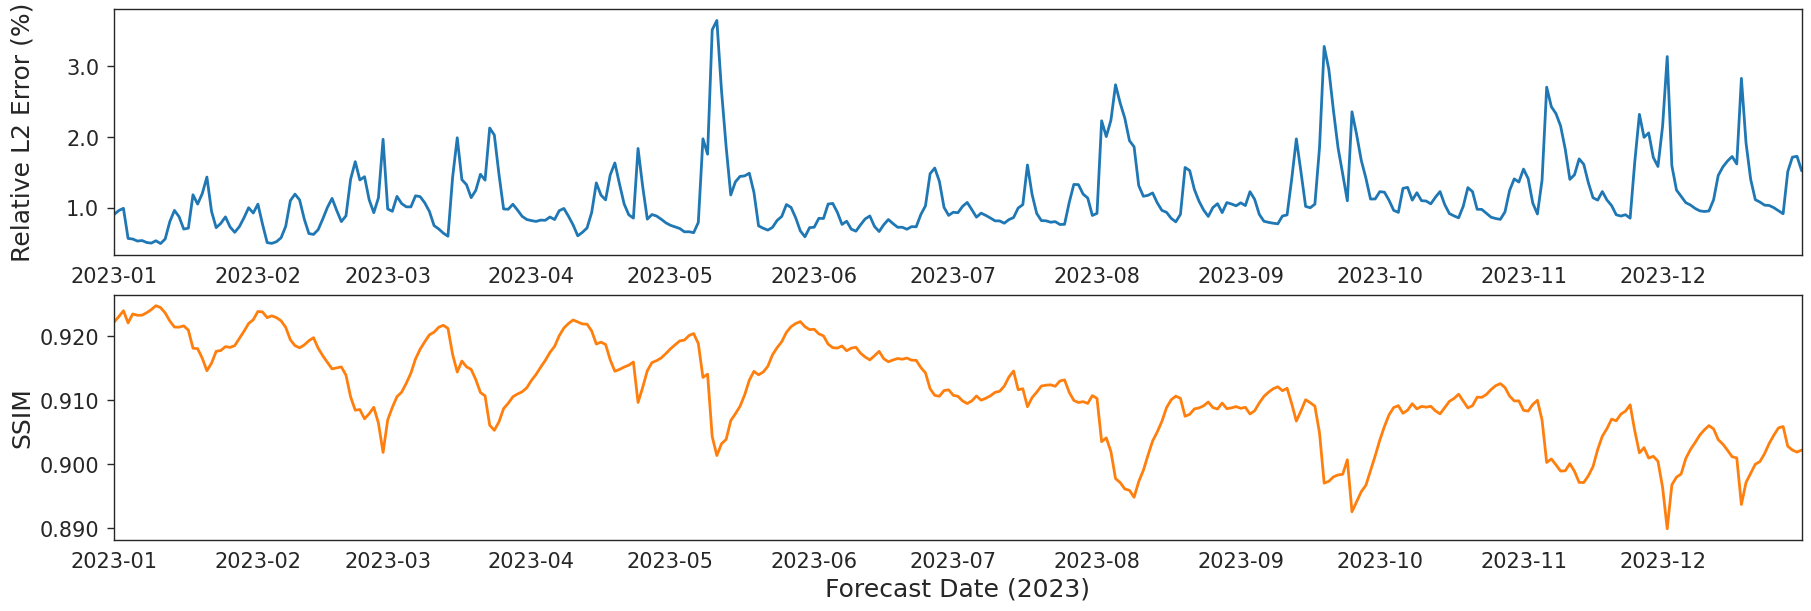

In [172]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

fig, ax = plt.subplots(2, 1, figsize=(18, 6), sharex=True, constrained_layout=True)

# month ticks/labels (use '%b' for Jan/Feb..., or '%Y-%m' for 2023-01)
month_locator = mdates.MonthLocator(interval=1)
month_fmt = mdates.DateFormatter('%Y-%m')

# --- top: Relative L2 ---
ax[0].plot(dates, l2, lw=2, color='tab:blue')
ax[0].set_ylabel('Relative L2 Error (%)', fontsize=18)
ax[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))

# --- bottom: SSIM ---
ax[1].plot(dates, ssim, lw=2, color='tab:orange')
ax[1].set_ylabel('SSIM', fontsize=18)
ax[1].set_xlabel('Forecast Date (2023)', fontsize=18)
ax[1].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.3f'))

# apply the SAME x tick locator/formatter to BOTH axes
for a in ax:
    a.xaxis.set_major_locator(month_locator)
    a.xaxis.set_major_formatter(month_fmt)
    # <-- CRUCIAL: re-enable top-axis labels even with sharex
    a.tick_params(axis='x', which='both', labelbottom=True, rotation=0)
    a.yaxis.set_ticks_position('left')
    a.yaxis.set_label_position('left')
    a.tick_params(axis='y', pad=6)
    # thick font size for x and y ticks
    a.tick_params(axis='x', labelsize=15)
    a.tick_params(axis='y', labelsize=15)

# nice alignment and limits
fig.align_ylabels(ax)
ax[1].set_xlim(dates[0], dates[-1])

plt.savefig('analysis/forecasting/forecast_metrics_2023.png', dpi=300)
plt.show()


In [155]:
# find 50th percentile dates for L2 and SSIM
l2_50th = np.percentile(l2, 50)
ssim_50th = np.percentile(ssim, 50)

idx_50pct = np.argmin(np.abs(l2 - l2_50th))
idx_50pct_ssim = np.argmin(np.abs(ssim - ssim_50th))

print("50th percentile Relative L2 Error: %.2f%% on %s" % (l2_50th, dates[idx_50pct].strftime('%Y-%m-%d')))
print("50th percentile SSIM: %.4f on %s" % (ssim_50th, dates[idx_50pct_ssim].strftime('%Y-%m-%d')))

50th percentile Relative L2 Error: 1.01% on 2023-03-05
50th percentile SSIM: 0.9107 on 2023-07-09


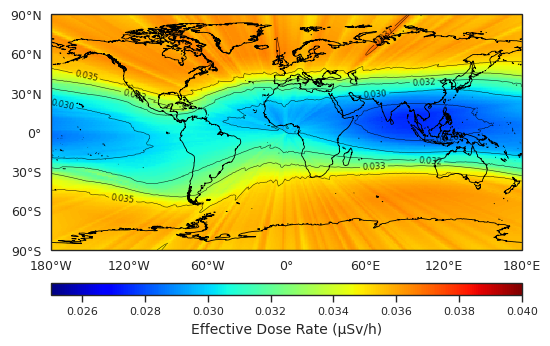

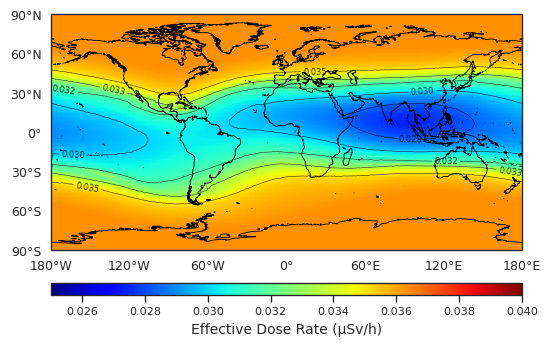

In [174]:
# convert index to date
date = dates[idx_50pct].date()


plot_field_region(
    lon_grid, lat_grid, pred_img, i=idx_50pct,
    #title=f"test {date}",
    units_label="Effective Dose Rate (µSv/h)",
    region_extent=[-180, 180, -90, 90],
    vmin=0.025, vmax=0.040,
    tick_step=(60, 30),
    add_contour=True, contour_levels=np.linspace(0.025, 0.040, 10),
    mark_equator_meridian=False,
    show_borders=False,
    cmap= 'jet',
    #savepath='analysis/forecasting/prediction_global.png'
)

plot_field_region(
    lon_grid, lat_grid, targ_img, i=idx_50pct,
    #title=f"test {date}",
    units_label="Effective Dose Rate (µSv/h)",
    region_extent=[-180, 180, -90, 90],
    vmin=0.025, vmax=0.040,
    tick_step=(60, 30),
    add_contour=True, contour_levels=np.linspace(0.025, 0.040, 10),
    mark_equator_meridian=False,
    show_borders=False,
    cmap= 'jet',
    #savepath='analysis/forecasting/target_global.png'
)

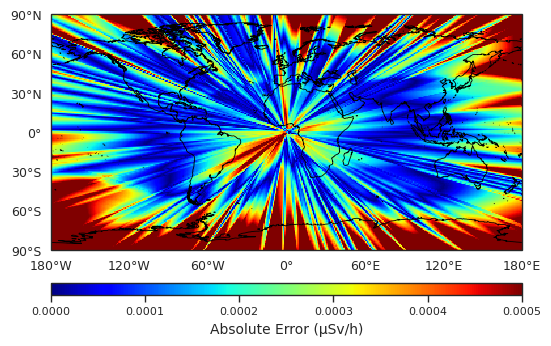

In [178]:
plot_field_region(
    lon_grid, lat_grid, np.abs((targ_img - pred_img)), i=idx_50pct,
    #title=f"test {date} - Error Map",
    units_label="Absolute Error (µSv/h)",
    region_extent=[-180, 180, -90, 90],
    vmin=0, vmax=5E-4,
    tick_step=(60, 30),
    #add_contour=True, contour_levels=np.linspace(0.025, 0.040, 5),
    mark_equator_meridian=False,
    show_borders=False,
    cmap= 'jet',
    #savepath='analysis/zero-shot/prediction_025deg_global.png'
)